In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from src.metrics import calculate_hypervolume
import importlib
import src.optimizer
importlib.reload(src.optimizer)
from src.optimizer import Optimizer
import src.ISPEA2Optimizer
importlib.reload(src.ISPEA2Optimizer)
from src.ISPEA2Optimizer import ISPEA2Optimizer
from src.network_creator import NetworkCreator
import random
import pandas as pd

In [57]:
def plot_hv_over_evaluations(hv_nsga2_all, hv_ispea2_all, generations, network_name):
    """
    Rysuje wykres średniej wartości hypervolume na przestrzeni generacji.
    - hv_nsga2_all, hv_ispea2_all: listy list (runs x generations)
    """
    hv_nsga2_mean = np.mean(hv_nsga2_all, axis=0)
    hv_nsga2_std = np.std(hv_nsga2_all, axis=0)

    hv_ispea2_mean = np.mean(hv_ispea2_all, axis=0)
    hv_ispea2_std = np.std(hv_ispea2_all, axis=0)

    x = np.arange(1, generations+1)

    plt.figure(figsize=(10,6))
    plt.plot(x, hv_nsga2_mean, label='NSGA-II', color='blue')
    plt.fill_between(x, hv_nsga2_mean - hv_nsga2_std, hv_nsga2_mean + hv_nsga2_std, alpha=0.2, color='blue')

    plt.plot(x, hv_ispea2_mean, label='ISPEA2', color='orange')
    plt.fill_between(x, hv_ispea2_mean - hv_ispea2_std, hv_ispea2_mean + hv_ispea2_std, alpha=0.2, color='orange')

    plt.xlabel("Number of generations")
    plt.ylabel("Hypervolume (HV)")
    plt.title(f"Hypervolume over Generations for {network_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

def run_experiment(network, start_node, end_node, population_size, generations, reference_point, runs=5):
    hv_nsga2_all = []
    hv_ispea2_all = []
    hv_nsga2_per_gen_all = []
    hv_ispea2_per_gen_all = []

    for i in range(runs):
        seed = 100 + i
        random.seed(seed)
        np.random.seed(seed)

        nsga2_opt = Optimizer(start_node, end_node, network, population_size, 0.2, 0.3, generations)
        ispea2_opt = ISPEA2Optimizer(start_node, end_node, network, population_size, 0.2, 0.3, generations)

        # Zmieniamy, by zwracały listę frontów na generację, np:
        fronts_nsga2 = nsga2_opt.nsga2_full_trace()  # lista frontów po każdej generacji
        fronts_ispea2 = ispea2_opt.run_full_trace()  # analogicznie

        hv_nsga2_per_gen = []
        hv_ispea2_per_gen = []

        def transform(front):
            for ind in front:
                ind.metrics = [-ind.metrics[0], ind.metrics[1], ind.metrics[2]]
            return front

        for gen_front in fronts_nsga2:
            front = transform(gen_front)
            hv = calculate_hypervolume(front, reference_point)
            hv_nsga2_per_gen.append(hv)

        for gen_front in fronts_ispea2:
            front = transform(gen_front)
            hv = calculate_hypervolume(front, reference_point)
            hv_ispea2_per_gen.append(hv)

        hv_nsga2_per_gen_all.append(hv_nsga2_per_gen)
        hv_ispea2_per_gen_all.append(hv_ispea2_per_gen)

        # Podsumowanie na końcu eksperymentu (ostatnia generacja)
        hv_nsga2_all.append(hv_nsga2_per_gen[-1])
        hv_ispea2_all.append(hv_ispea2_per_gen[-1])

    return hv_nsga2_all, hv_ispea2_all, hv_nsga2_per_gen_all, hv_ispea2_per_gen_all

def run_all():
    reference_point = [0, 1000, 1.0]
    generations = 10
    runs = 5

    sizes = [1, 5, 10]
    networks = {
        "full_mesh_20": NetworkCreator().create_full_mesh_network(20),
        "full_mesh_40": NetworkCreator().create_full_mesh_network(40),
        "janos-us-ca": NetworkCreator("network_source/janos-us-ca").create_physical_network()
    }

    start_node = "1"
    end_node = "2"
    start_real = "Portland"
    end_real = "Miami"

    results = []

    for net_name, net in networks.items():
        print(f"\n--- Testing on network: {net_name} ---")
        for size in sizes:
            print(f"\n  >> Running for population size = {size}")
            s_node = start_node if "full" in net_name else start_real
            e_node = end_node if "full" in net_name else end_real

            hv_nsga2, hv_ispea2, hv_nsga2_per_gen, hv_ispea2_per_gen = run_experiment(net, s_node, e_node, size, generations, reference_point, runs)

            # Rysuj wykres dla bieżącej sieci i populacji
            plot_hv_over_evaluations(hv_nsga2_per_gen, hv_ispea2_per_gen, generations, f"{net_name} (Pop={size})")

            results.append({
                "Network": net_name,
                "PopSize": size,
                "NSGA-II HV Mean": np.mean(hv_nsga2),
                "NSGA-II HV Std": np.std(hv_nsga2),
                "ISPEA2 HV Mean": np.mean(hv_ispea2),
                "ISPEA2 HV Std": np.std(hv_ispea2),
            })

    df_results = pd.DataFrame(results)
    print(df_results)
    return df_results


In [58]:
def plot_results_bar(df_results):
    networks = df_results["Network"].unique()
    pop_sizes = df_results["PopSize"].unique()
    
    fig, ax = plt.subplots(figsize=(12, 6))

    width = 0.35  # szerokość słupka
    x = np.arange(len(networks)*len(pop_sizes))

    nsga2_means = []
    ispea2_means = []
    labels = []

    for net in networks:
        for pop in pop_sizes:
            row = df_results[(df_results["Network"]==net) & (df_results["PopSize"]==pop)]
            nsga2_means.append(float(row["NSGA-II HV Mean"].iloc[0]))
            ispea2_means.append(float(row["ISPEA2 HV Mean"].iloc[0]))
            labels.append(f"{net}\nPop={pop}")

    ax.bar(x - width/2, nsga2_means, width, label='NSGA-II')
    ax.bar(x + width/2, ispea2_means, width, label='ISPEA2')

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel("Mean Hypervolume (HV)")
    ax.set_title("Porównanie średnich HV dla NSGA-II i ISPEA2")
    ax.legend()
    ax.grid(axis='y')

    plt.tight_layout()
    plt.show()



--- Testing on network: full_mesh_20 ---

  >> Running for population size = 1


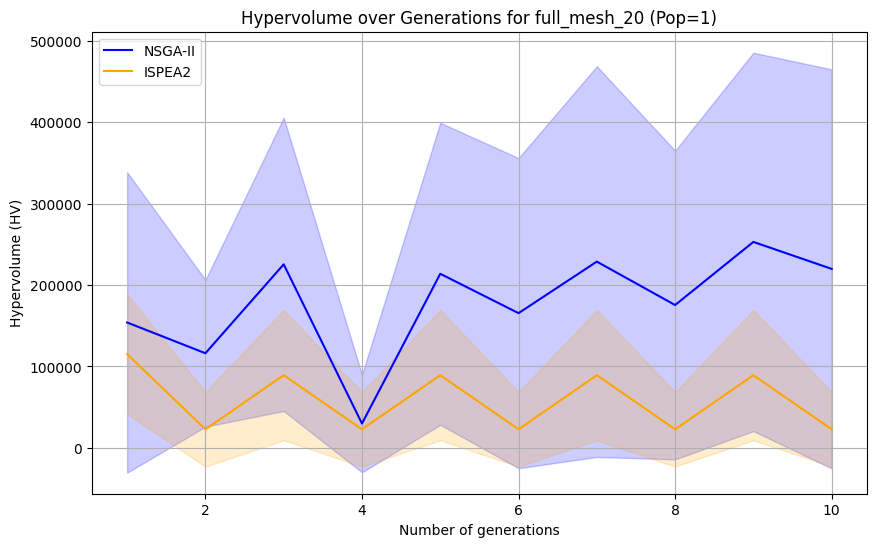


  >> Running for population size = 5


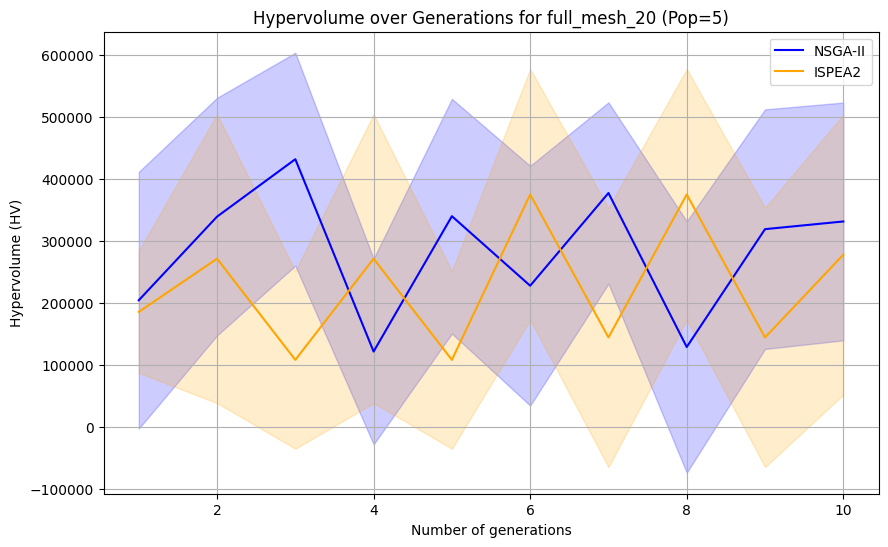


  >> Running for population size = 10


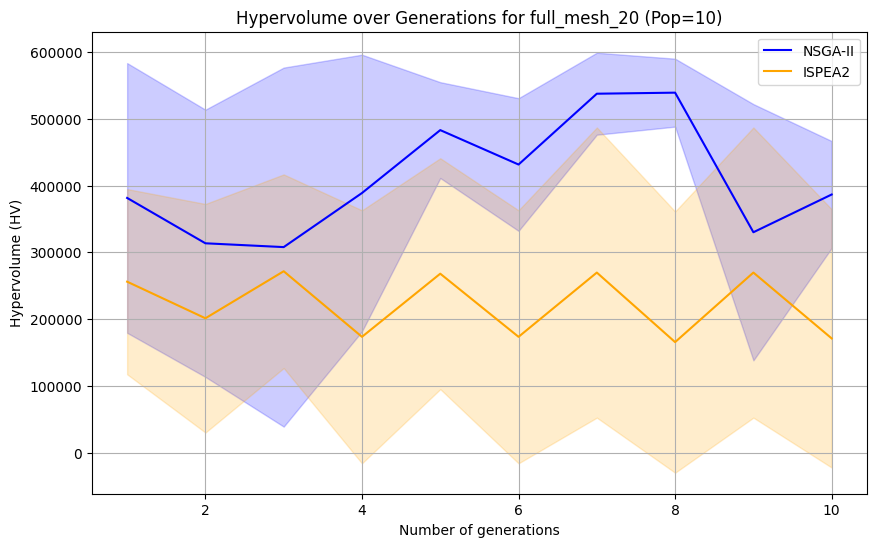


--- Testing on network: full_mesh_40 ---

  >> Running for population size = 1


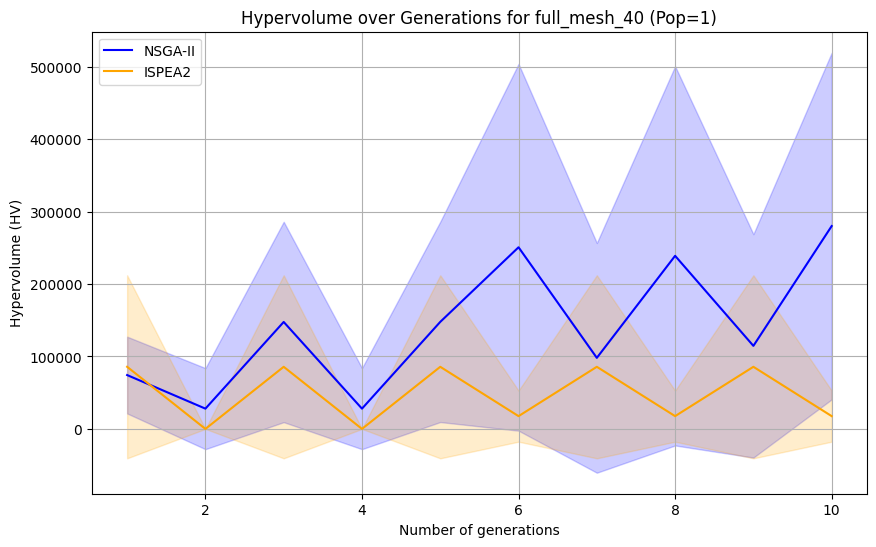


  >> Running for population size = 5


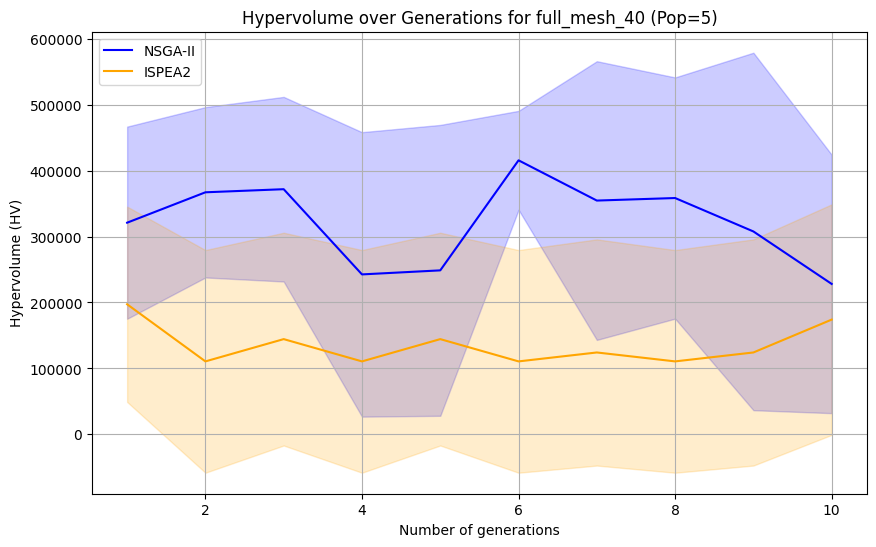


  >> Running for population size = 10


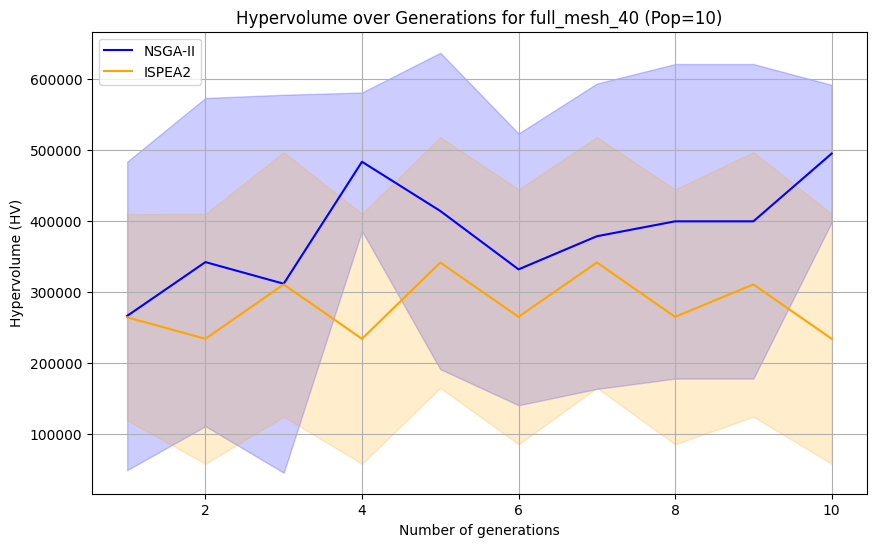


--- Testing on network: janos-us-ca ---

  >> Running for population size = 1


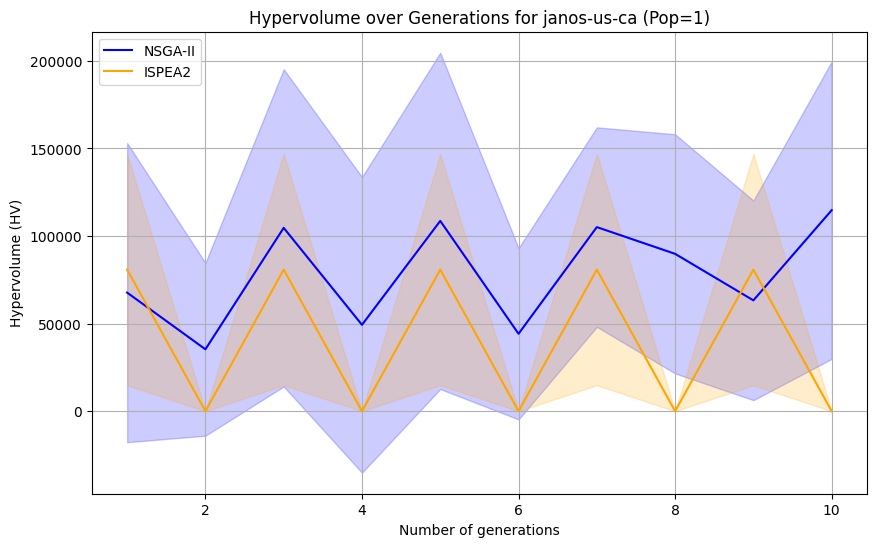


  >> Running for population size = 5


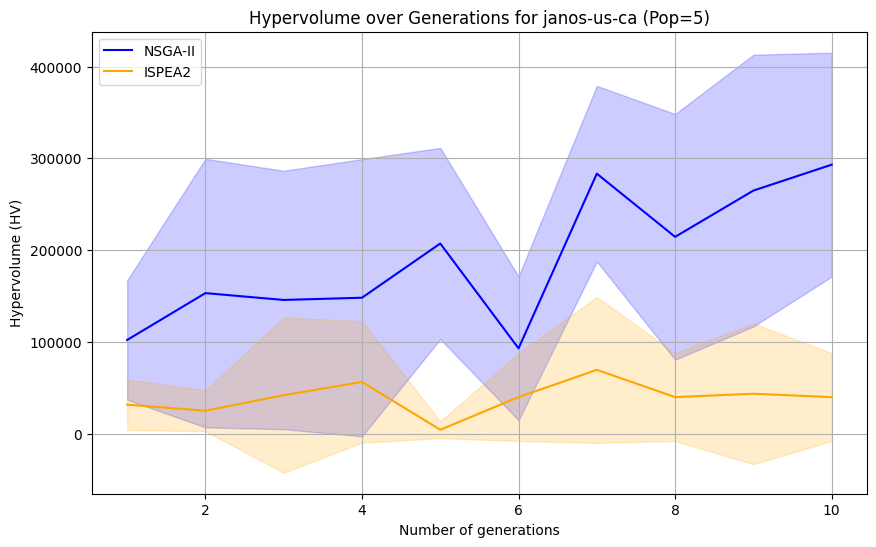


  >> Running for population size = 10


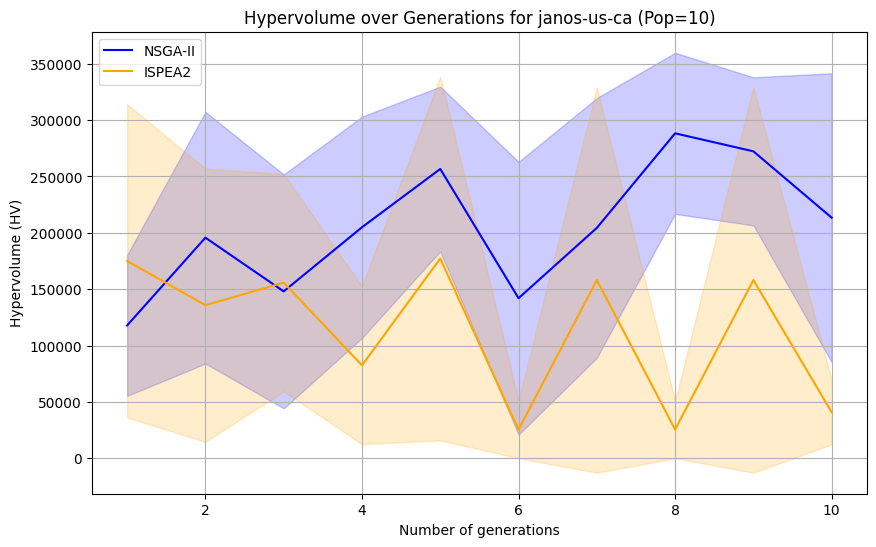

        Network  PopSize  NSGA-II HV Mean  NSGA-II HV Std  ISPEA2 HV Mean  \
0  full_mesh_20        1      219765.3240   244927.067998      22863.9576   
1  full_mesh_20        5      331819.0648   192001.602285     278149.9520   
2  full_mesh_20       10      386640.4728    80151.193743     170988.7996   
3  full_mesh_40        1      280019.3056   239256.931225      17636.5980   
4  full_mesh_40        5      228148.7740   196025.253680     174027.9236   
5  full_mesh_40       10      494507.0608    96750.200687     233615.4038   
6   janos-us-ca        1      114717.7464    84894.627633          0.0000   
7   janos-us-ca        5      293135.1644   121884.340226      40105.6696   
8   janos-us-ca       10      213407.4240   128076.880947      40897.5840   

   ISPEA2 HV Std  
0   45727.915200  
1  225922.801208  
2  193535.829057  
3   35273.196000  
4  174835.111510  
5  175991.760612  
6       0.000000  
7   47751.142262  
8   28416.331067  


In [59]:
df=run_all()


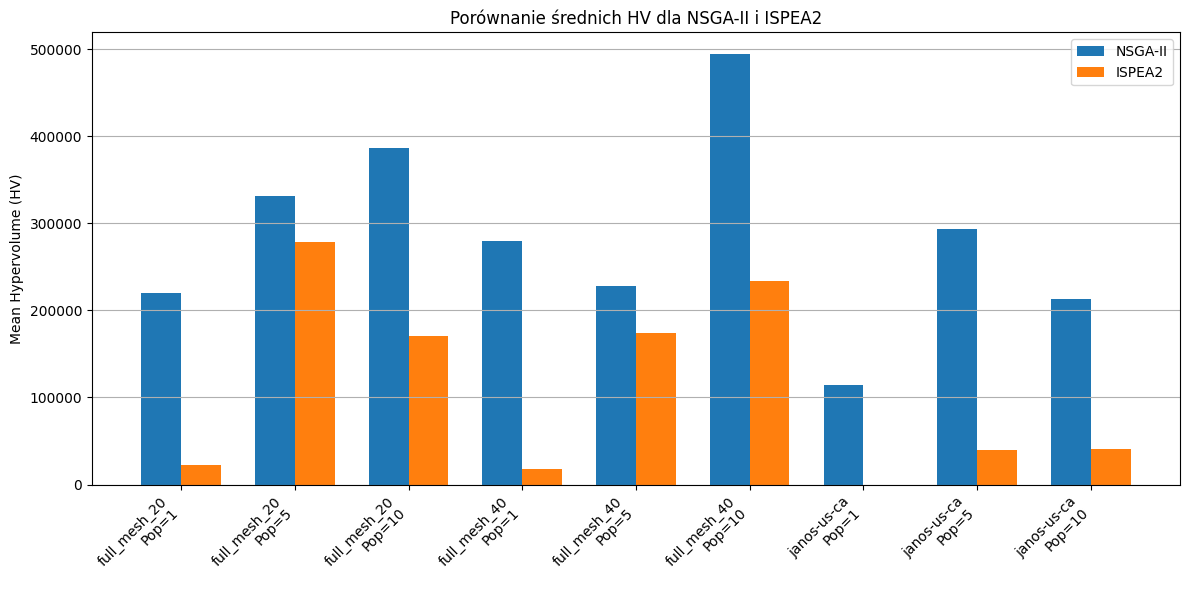

In [60]:
plot_results_bar(df)